### Text Preprocessing


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from utils import tokenize_text, make_input, scale

from datetime import datetime

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kent\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kent\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load Dataset


Setup Training Set Dataframe


In [2]:
columns=['sentiment', 'tweet_id', 'date', 'query', 'user', 'text']
train_df = pd.read_csv("./data/training.1600000.processed.noemoticon.csv", names=columns, encoding='latin-1')
train_df = train_df.loc[:, ['sentiment', 'text']]

In [3]:
train_df.groupby('sentiment').count()

,text
sentiment,
0,800000
4,800000


In [4]:
EACH_SAMPLE_SIZE = 500

In [5]:
negative_train = train_df[train_df['sentiment'] == 0].dropna().reset_index(drop=True)
positive_train = train_df[train_df['sentiment'] == 4].dropna().reset_index(drop=True)
positive_train['sentiment'] = 1

positive_train = positive_train[0:EACH_SAMPLE_SIZE]
negative_train = negative_train[0:EACH_SAMPLE_SIZE]

print("Positive Training Set:", len(positive_train), end=f"\n{"-"*70}\n")
print(positive_train.head(), end=f"\n\n{"="*70}\n\n")
print("Negative Training Set:", len(negative_train))
print(negative_train.head(), end=f"\n{"-"*70}\n")

Positive Training Set: 500
----------------------------------------------------------------------
   sentiment                                               text
0          1       I LOVE @Health4UandPets u guys r the best!! 
1          1  im meeting up with one of my besties tonight! ...
2          1  @DaRealSunisaKim Thanks for the Twitter add, S...
3          1  Being sick can be really cheap when it hurts t...
4          1    @LovesBrooklyn2 he has that effect on everyone 


Negative Training Set: 500
   sentiment                                               text
0          0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1          0  is upset that he can't update his Facebook by ...
2          0  @Kenichan I dived many times for the ball. Man...
3          0    my whole body feels itchy and like its on fire 
4          0  @nationwideclass no, it's not behaving at all....
----------------------------------------------------------------------


In [6]:
pos_train_text = positive_train['text'].str.cat(sep=" ")
neg_train_text = negative_train['text'].str.cat(sep=" ")

print('pos_train_text:', len(pos_train_text))
print('negative_train:', len(neg_train_text))

pos_train_text: 38995
negative_train: 38912


In [7]:
tokenized_pos_train_text = tokenize_text(pos_train_text)
tokenized_neg_train_text = tokenize_text(neg_train_text)

print('tokenized_pos_train_text', type(tokenized_pos_train_text), "| len:", len(tokenized_pos_train_text))
print(
    "tokenized_neg_train_text",
    type(tokenized_neg_train_text),
    "| len:",
    len(tokenized_neg_train_text),
)

tokenized_pos_train_text <class 'list'> | len: 3515
tokenized_neg_train_text <class 'list'> | len: 3593


In [8]:
vocabulary = set(tokenized_pos_train_text + tokenized_neg_train_text)
vocabulary = list(vocabulary)

In [9]:
len(vocabulary)

2504

In [10]:
vocabulary_df = pd.DataFrame(vocabulary, columns=["vocabulary"])
vocabulary_df

,vocabulary
0,fav
1,sd
2,pool
3,rulesss
4,taken
...,...
2499,trainer
2500,experienc
2501,save
2502,excel


In [11]:
def make_dictionary(vocabulary: list[str], tokenized_pos_train_text: list[str], tokenized_neg_train_text: list[str]):
    pos_freqs = []
    neg_freqs = []
    for _, vtoken in enumerate(vocabulary):
        pos_count = 0
        neg_count = 0
        for token in tokenized_pos_train_text:
            if  vtoken == token:
                pos_count += 1
        pos_freqs.append(pos_count)

        for token in tokenized_neg_train_text:
            if  vtoken == token:
                neg_count += 1
        neg_freqs.append(neg_count)

    dictionary = [vocabulary, pos_freqs, neg_freqs]
    dictionary = np.array(dictionary).T
    return pd.DataFrame(dictionary, columns=["vocabulary", "pos_freq", "neg_freq"])

In [12]:
dictionary = make_dictionary(vocabulary=vocabulary, tokenized_pos_train_text=tokenized_pos_train_text, tokenized_neg_train_text=tokenized_neg_train_text)
dictionary['pos_freq'] = dictionary['pos_freq'].astype(pd.Int64Dtype())
dictionary['neg_freq'] = dictionary['neg_freq'].astype(pd.Int64Dtype())

dictionary

,vocabulary,pos_freq,neg_freq
0,fav,1,0
1,sd,0,1
2,pool,0,1
3,rulesss,1,0
4,taken,1,1
...,...,...,...
2499,trainer,1,0
2500,experienc,1,0
2501,save,1,3
2502,excel,2,0


In [13]:
timestamp = datetime.now().strftime("%m-%d-%Y-%H-%M-%S-%f")
dictionary.to_csv(f"./dictionaries/{EACH_SAMPLE_SIZE*2}_dictionary_{timestamp}.csv", index=False)

### Visualize Words Frequency by the WordCloud


In [14]:
from wordcloud import WordCloud, STOPWORDS

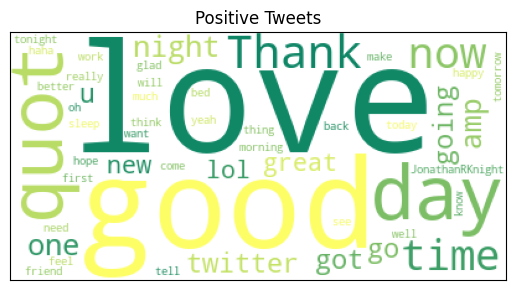

In [15]:
pos_wordcloud = WordCloud(background_color="white", max_words=50, stopwords=set(STOPWORDS), colormap="summer")
pos_wordcloud.generate(pos_train_text)

plt.xticks([])
plt.yticks([])
plt.title("Positive Tweets")
plt.imshow(pos_wordcloud)
plt.show()

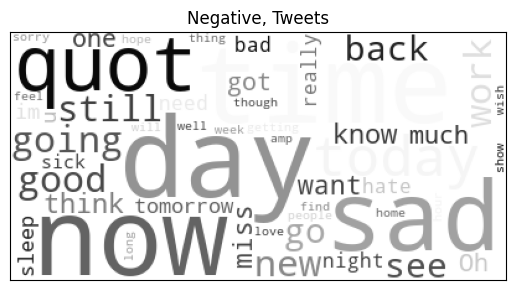

In [16]:
neg_wordcloud = WordCloud(background_color="white", max_words=50, stopwords=set(STOPWORDS), colormap="binary")
neg_wordcloud.generate(neg_train_text)

plt.xticks([])
plt.yticks([])
plt.title("Negative, Tweets")
plt.imshow(neg_wordcloud)
plt.show()

### Make a training set for Logistic Regression: Extract Features and Scale


In [17]:
dict_pos_freqs = dictionary['pos_freq'].to_list()
dict_neg_freqs = dictionary['neg_freq'].to_list()

In [18]:
def make_training_set(scaling: str, no_bias: bool, pos_freqs: list[str], neg_freqs: list[str], vocabulary: list[str]):

    training_set = []
    x_train = []
    y_train = []
    
    bias = 1
    
    pos_train = positive_train.loc[:, ['text', 'sentiment']]
    neg_train = negative_train.loc[:, ['text', 'sentiment']]

    for _, row in pos_train.iterrows():
        pos_total = 0
        neg_total = 0
        for token in tokenize_text(row['text']):
            for j, vtoken in enumerate(vocabulary):
                if token == vtoken:
                    pos_total += pos_freqs[j]
                    neg_total += neg_freqs[j]

        pos_total, neg_total = scale(scaling=scaling, pos_total=pos_total, neg_total=neg_total, pos_freqs=pos_freqs, neg_freqs=neg_freqs)
        
        xi_train = [pos_total, neg_total] if no_bias else [bias, pos_total, neg_total]
        
        training_set.append((xi_train, [1 if pos_total > neg_total else 0]))

        x_train.append(xi_train)
        y_train.append([1 if pos_total > neg_total else 0])

    for _, row in neg_train.iterrows():
        pos_total = 0
        neg_total = 0
        for token in tokenize_text(row['text']):
            for j, vtoken in enumerate(vocabulary):
                if token == vtoken:
                    pos_total += pos_freqs[j]
                    neg_total += neg_freqs[j]

        pos_total, neg_total = scale(scaling=scaling, pos_total=pos_total, neg_total=neg_total, pos_freqs=pos_freqs, neg_freqs=neg_freqs)

        xi_train = [pos_total, neg_total] if no_bias else [bias, pos_total, neg_total]
        
        training_set.append((xi_train, [1 if pos_total > neg_total else 0]))

        x_train.append(xi_train)
        y_train.append([1 if pos_total > neg_total else 0])

    return (training_set, x_train, y_train)

In [19]:
# no_bias_training_set = make_training_set(scaling='standardize', no_bias=True)
with_bias_training_set = make_training_set(scaling='sqrt', no_bias=False, pos_freqs=dict_pos_freqs, neg_freqs=dict_neg_freqs, vocabulary=vocabulary)

In [20]:
training_df = pd.DataFrame(with_bias_training_set[1], columns=["bias", "pos_freq", "neg_freq"])
training_df['label']  = pd.Series(with_bias_training_set[2]).apply(lambda x: x[0])

In [21]:
timestamp = datetime.now().strftime("%m-%d-%Y-%H-%M-%S-%f")
training_df.to_csv(f"./training_sets/{EACH_SAMPLE_SIZE*2}_training_set_{timestamp}.csv", index=False)

### Setup Pytorch


Imports necessary libraries from torch


In [22]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torch.optim import SGD
from torch.nn import BCELoss

Setup Dataset and Data Loader


In [23]:
class TwitterDataset(Dataset):
    def __init__(self, dataset) -> None:
        super(TwitterDataset, self).__init__()
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        return self.dataset[index]

In [24]:
training_set, X, Y = with_bias_training_set

In [25]:
dataset = TwitterDataset(dataset=training_set)
dataset_loader = DataLoader(dataset=dataset, batch_size=32)

Define the logistic regression model


In [26]:
class Classifier(nn.Module):
    def __init__(self, in_features: int):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features=1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

Initialize the model, loss, and optimizer


In [27]:
model = Classifier(in_features=3)
criterion = BCELoss()
optimizer = SGD(model.parameters(), lr=0.0001, weight_decay=0.01)

### Train the model using my custom training loop


In [28]:
epoch = 1000
m = len(dataset_loader)
for e in range(epoch):
    for i, (x, y) in enumerate(dataset_loader):
        x = torch.stack(x).to(dtype=torch.float32).T
        y = torch.stack(y).to(dtype=torch.float32).T

        yhat = model(x)
        loss = criterion(yhat, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1 == m) and (e % 100 == 0) or (i == m - 1 and e == epoch - 1):
            print("Epoch", e ,"|", "Loss", loss.item())

Epoch 0 | Loss 0.6274386048316956
Epoch 100 | Loss 0.7319617867469788
Epoch 200 | Loss 0.682016909122467
Epoch 300 | Loss 0.63954758644104
Epoch 400 | Loss 0.6035975813865662
Epoch 500 | Loss 0.5730006098747253
Epoch 600 | Loss 0.546736478805542
Epoch 700 | Loss 0.5239683985710144
Epoch 800 | Loss 0.5040361285209656
Epoch 900 | Loss 0.4864210784435272
Epoch 999 | Loss 0.4708681106567383


### Save the model


In [29]:
timestamp = datetime.now().strftime("%m-%d-%Y-%H-%M-%S-%f")
torch.save(model.state_dict(), f"./models/{EACH_SAMPLE_SIZE*2}_sentiment_analysis_{timestamp}.pt")

### Test the model accuracy


In [30]:
test_df = pd.read_csv("./data/testdata.manual.2009.06.14.csv", names=columns)
test_df = test_df.loc[:, ["text", "sentiment"]]

In [31]:
test_df.groupby('sentiment').count()

,text
sentiment,
0,177
2,139
4,182


In [32]:
negative_test = test_df[test_df['sentiment'] == 0].dropna().reset_index(drop=True)
positive_test = test_df[test_df['sentiment'] == 4].dropna().reset_index(drop=True)
positive_test['sentiment'] = 1

print("Positive Test Set", end=f"\n{"-"*70}\n")
print(positive_test.head(), end=f"\n\n{"="*70}\n\n")
print("Negative Test Set")
print(negative_test.head(), end=f"\n{"-"*70}\n")

Positive Test Set
----------------------------------------------------------------------
                                                text  sentiment
0  @stellargirl I loooooooovvvvvveee my Kindle2. ...          1
1  Reading my kindle2...  Love it... Lee childs i...          1
2  Ok, first assesment of the #kindle2 ...it fuck...          1
3  @kenburbary You'll love your Kindle2. I've had...          1
4  @mikefish  Fair enough. But i have the Kindle2...          1


Negative Test Set
                                                text  sentiment
0  Fuck this economy. I hate aig and their non lo...          0
1  @Karoli I firmly believe that Obama/Pelosi hav...          0
2  dear nike, stop with the flywire. that shit is...          0
3  I was talking to this guy last night and he wa...          0
4  @ludajuice Lebron is a Beast, but I'm still ch...          0
----------------------------------------------------------------------


In [33]:
pos_test_text = positive_test['text'].str.cat(sep=" ")
neg_test_text = negative_test['text'].str.cat(sep=" ")

print('pos_test_text:', len(pos_test_text))
print('negative_test:', len(neg_test_text))

pos_test_text: 15161
negative_test: 15161


In [34]:
def make_testing_set(pos_test: pd.DataFrame, neg_test: pd.DataFrame, scaling: str, no_bias: bool, pos_freqs: list[str], neg_freqs: list[str], vocabulary: list[str]):
    testing_set = []
    x_test = []
    y_test = []

    for _, row in pos_test.iterrows():
        pos_total = 0
        neg_total = 0
        for token in tokenize_text(row['text']):
            for i, vtoken in enumerate(vocabulary):
                if token == vtoken:
                    pos_total += pos_freqs[i]
                    neg_total += neg_freqs[i]
        
        pos_total, neg_total = scale(scaling, pos_total, neg_total, pos_freqs, neg_freqs)

        xi_test = [pos_total, neg_total] if no_bias else [1, pos_total, neg_total]

        testing_set.append((xi_test, [1 if pos_total > neg_total else 0]))

        x_test.append(xi_test)
        y_test.append([1 if pos_total > neg_total else 0])

    for _, row in neg_test.iterrows():
        pos_total = 0
        neg_total = 0
        for token in tokenize_text(row['text']):
            for i, vtoken in enumerate(vocabulary):
                if token == vtoken:
                    pos_total += pos_freqs[i]
                    neg_total += neg_freqs[i]
        
        pos_total, neg_total = scale(scaling, pos_total, neg_total, pos_freqs, neg_freqs)

        xi_test = [pos_total, neg_total] if no_bias else [1, pos_total, neg_total]

        testing_set.append((xi_test, [1 if pos_total > neg_total else 0]))

        x_test.append(xi_test)
        y_test.append([1 if pos_total > neg_total else 0])
    
    return (testing_set, x_test, y_test)

In [35]:
with_bias_testing_set = make_testing_set(pos_test=positive_test, neg_test=negative_test, scaling='sqrt', no_bias=False, pos_freqs=dict_pos_freqs, neg_freqs=dict_neg_freqs, vocabulary=vocabulary)

In [36]:
testing_set, x_test, y_test = with_bias_testing_set

In [37]:
testing_set[0:10]

[([1, 2.449489742783178, 3.3166247903554], [0]),
 ([1, 10.583005244258363, 7.0], [1]),
 ([1, 4.69041575982343, 3.3166247903554], [1]),
 ([1, 11.874342087037917, 10.344080432788601], [1]),
 ([1, 4.58257569495584, 5.385164807134504], [0]),
 ([1, 4.123105625617661, 2.6457513110645907], [1]),
 ([1, 6.164414002968976, 4.69041575982343], [1]),
 ([1, 8.48528137423857, 3.7416573867739413], [1]),
 ([1, 8.06225774829855, 4.58257569495584], [1]),
 ([1, 9.055385138137417, 7.810249675906654], [1])]

In [38]:
predictions = []
y_label = np.array(with_bias_testing_set[2]).flatten()

with torch.inference_mode():
    for i, (x, y) in enumerate(testing_set):
        x = torch.as_tensor(x).to(dtype=torch.float32)
        y = torch.as_tensor(y).to(dtype=torch.float32)
        yhat = model(x)

        for prediction in yhat:
            predictions.append(1 if prediction > 0.5 else 0)

predictions = np.array(predictions) == y_label
accuracy = predictions.sum()  / len(predictions)
print("Accuracy:", accuracy)

Accuracy: 0.9415041782729805


In [39]:
test = make_input("i love you", scaling="sqrt", pos_freqs=dict_pos_freqs, neg_freqs=dict_neg_freqs, vocabulary=vocabulary)
test

tensor([1.0000, 7.0000, 3.4641])

In [40]:
with torch.inference_mode():
    yhat_test = model(test) 
yhat_test

tensor([0.8618])